# Event detection algorithms

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

In [3]:
from nilmtk.dataset import DataSet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [4]:
from event_detection.plotting.events import plot_events, plot_statistics
from event_detection.detectors import HartDetector, GLRDetector, GLRVoteDetector, GLRMaximaDetector, GLRCUMVoteDetector, GOFDetector, GOFVoteDetector

In [5]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8,5) 

## Import ECO dataset

Please remember to change to your target path and dataset name. By default it is assumed that your dataset is located in:
```
~/Documents/DataSets/{dataset_name}/{lower_case_dataset_name}.h5
```

In [6]:
data_path = Path().home().joinpath('Documents', 'DataSets')
dataset_name = "ECO"

In [7]:
data = DataSet(data_path.joinpath(dataset_name, f"{dataset_name.lower()}.h5"))

### Select period and house

In [8]:
house_n = 1
data.set_window("2012-06-01 00:00", "2012-06-07 00:00")
house = data.buildings[house_n].elec
mains = house.mains()
submeters = house.submeters()

### Load aggregated consumption

In [9]:
mains_gen = mains.load(physical_quantity='power', ac_type='active', sample_period=1)
mains_df = pd.DataFrame()
for section in mains_gen:
    mains_df = pd.concat([mains_df, section])

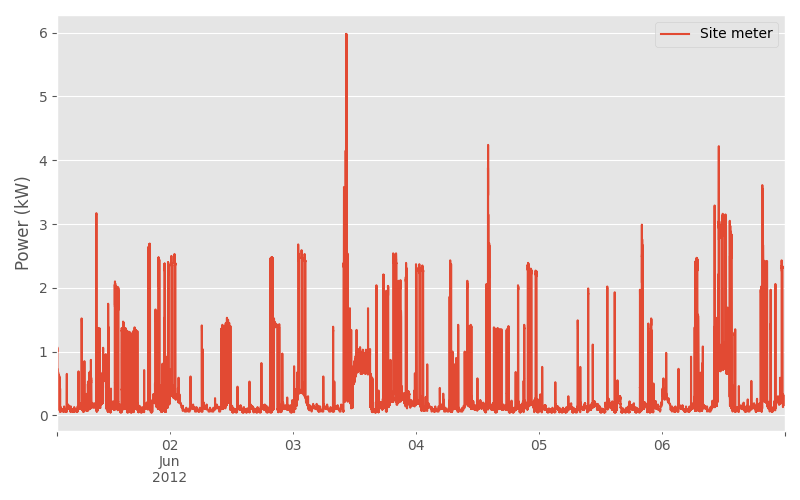

In [10]:
fig = plt.figure()
mains.plot(unit='kW', physical_quantity='power', ac_type='active', sample_period=1, kind="sum")
plt.tight_layout()

### Virtual Aggregated consumption

In [11]:
submeters_gen = submeters.load(physical_quantity='power', ac_type='active', sample_period=1)
submeters_df = pd.DataFrame()
for section in submeters_gen:
    submeters_df = pd.concat([submeters_df, section])

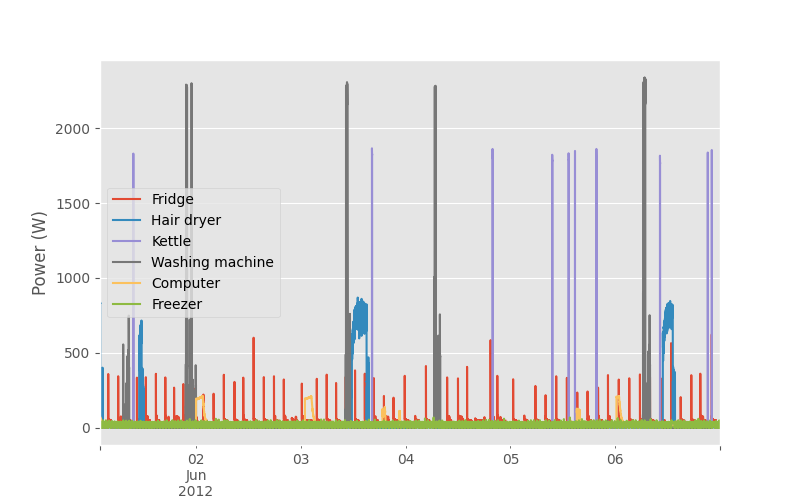

In [12]:
fig = plt.figure()
submeters.plot(physical_quantity='power', ac_type='active', sample_period=3)
plt.show()

## Test event detection algorithms

In [13]:
input_ts = submeters_df.copy()

In [14]:
min_power = 1000.0

### Fill NaN and apply median filter to aggregated signal

In [15]:
input_ts.bfill(inplace=True)

In [16]:
from scipy.ndimage import median_filter
input_ts[('power', 'filtered')] = median_filter(input_ts[[('power', 'active')]].values, size=5)

### Hart Dectector

In [17]:
hart_detector = HartDetector(event_threshold=min_power, state_threshold=min_power, min_n_samples=2)
hart_events = hart_detector.offline_events(pd.DataFrame(input_ts[("power", "filtered")]), detailed=False)

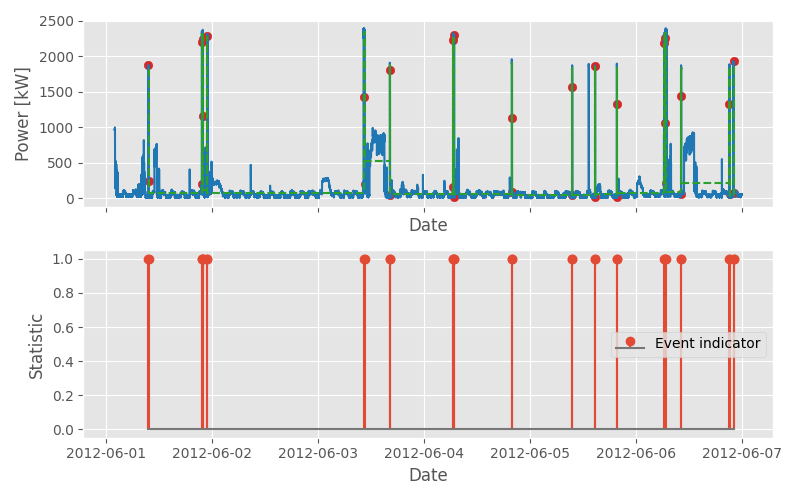

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(8 ,5), sharex=True)
plot_events(input_ts[("power", "filtered")], hart_events.delta_median, hart_events.pos_event_median, ax[0])
plot_statistics(hart_events.statistic_1, ax[1])
plt.tight_layout()

### GLR (Generalised Likelihood Ratio)

In [19]:
glr_detector = GLRDetector(event_threshold=min_power, stat_window=(5,5), stat_threshold=150, range_std=(1.0,10.0))
glr_events = glr_detector.offline_events(pd.DataFrame(input_ts[("power", "filtered")]))

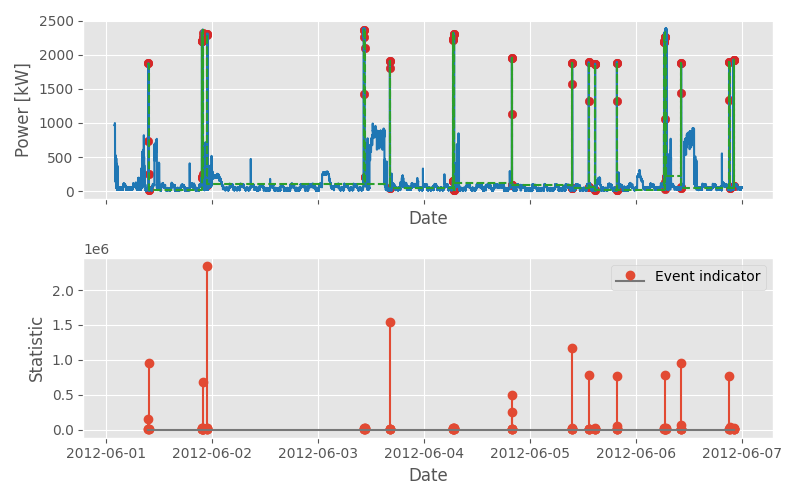

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(8 ,5), sharex=True)
plot_events(input_ts[("power", "filtered")], glr_events.delta_median, glr_events.pos_event_median, ax[0])
plot_statistics(glr_events.statistic_1, ax[1])
plt.tight_layout()

### GLR with voting window

In [21]:
glr_vote_detector = GLRVoteDetector(event_threshold=min_power, stat_window=(5,5), event_window=10, vote_threshold=8, range_std=(1.0,1.0))
glr_vote_events = glr_vote_detector.offline_events(pd.DataFrame(input_ts[("power", "filtered")]))

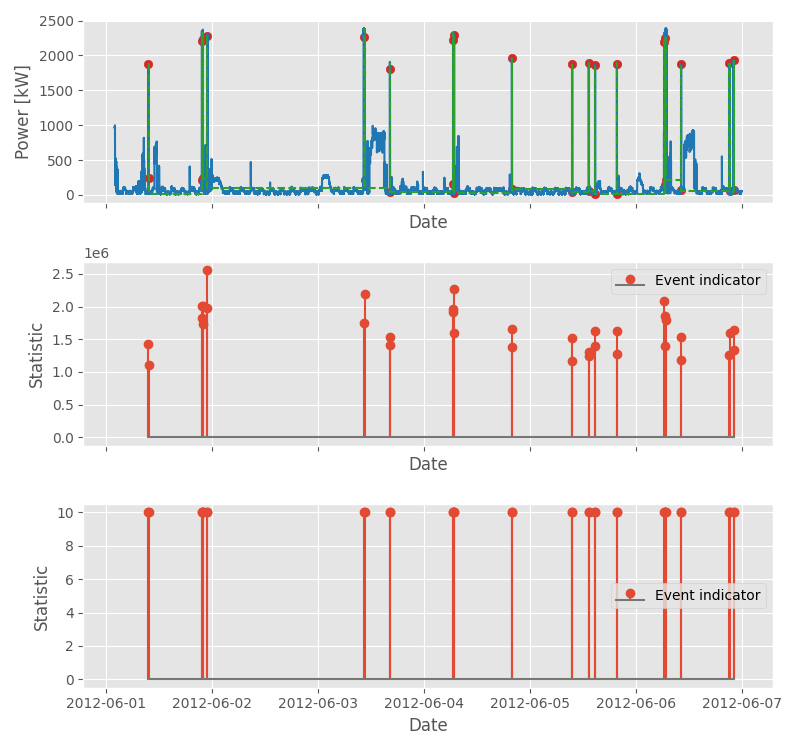

In [22]:
fig, ax = plt.subplots(3, 1, figsize=(8 ,7.5), sharex=True)
plot_events(input_ts[("power", "filtered")], glr_vote_events.delta_median, glr_vote_events.pos_event_median, ax[0])
plot_statistics(glr_vote_events.statistic_1, ax[1])
plot_statistics(glr_vote_events.statistic_2, ax[2])
plt.tight_layout()

### GLR with maxima window

In [23]:
glr_max_detector = GLRMaximaDetector(event_threshold=min_power, stat_window=(5,5), maxima_precision=5, range_std=(1.0,1.0))
glr_max_events = glr_max_detector.offline_events(pd.DataFrame(input_ts[("power", "filtered")]))

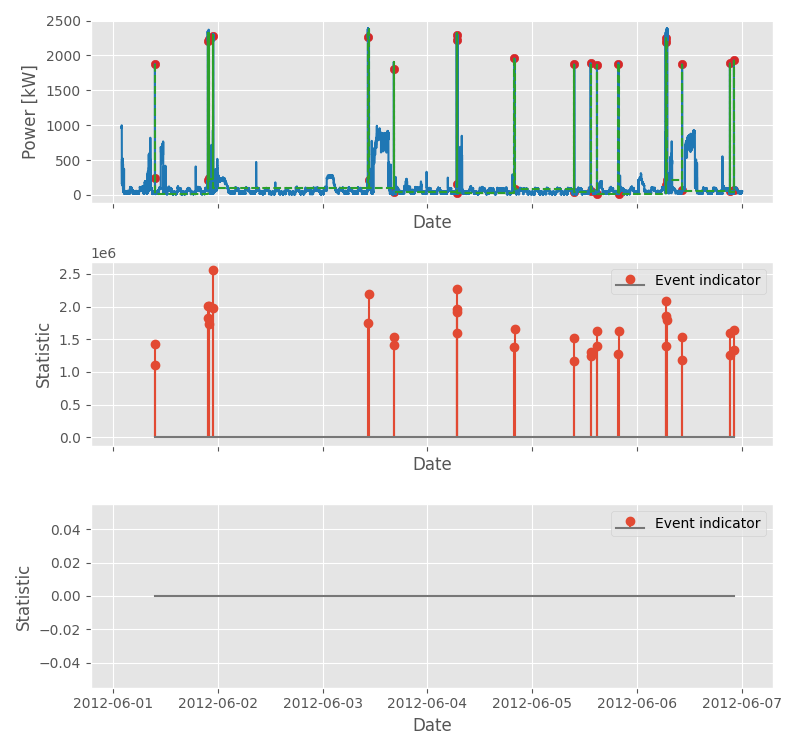

In [24]:
fig, ax = plt.subplots(3, 1, figsize=(8 ,7.5), sharex=True)
plot_events(input_ts[("power", "filtered")], glr_max_events.delta_median, glr_max_events.pos_event_median, ax[0])
plot_statistics(glr_max_events.statistic_1, ax[1])
plot_statistics(glr_max_events.statistic_2, ax[2])
plt.tight_layout()

### GLR CUM with voting window

In [38]:
glr_cum_vote_detector = GLRCUMVoteDetector(event_threshold=min_power, stat_window=(15,15), event_window=10, vote_threshold=8, range_std=(1.0,1.0))
glr_cum_vote_events = glr_cum_vote_detector.offline_events(pd.DataFrame(input_ts[("power", "filtered")]))

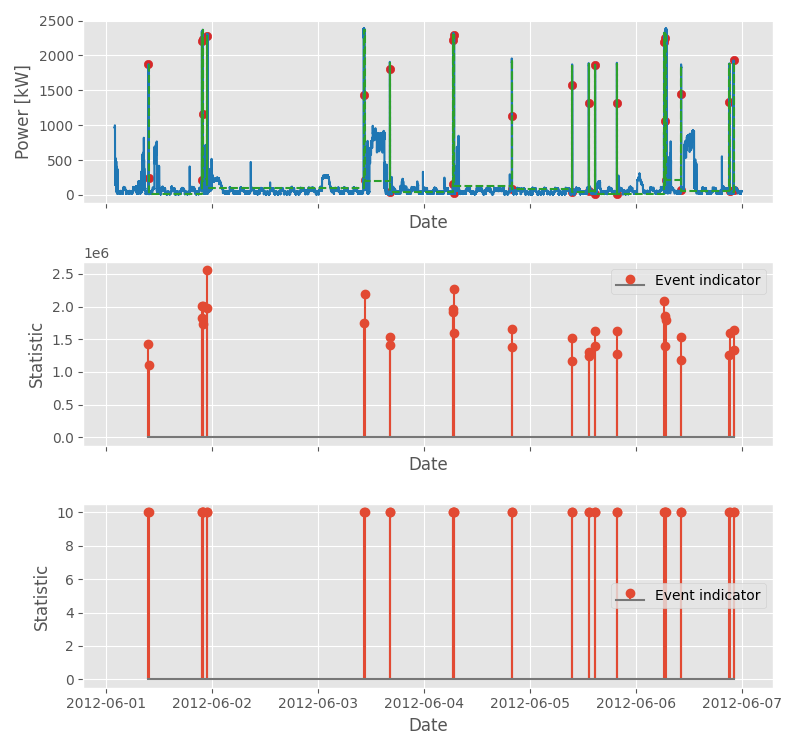

In [39]:
fig, ax = plt.subplots(3, 1, figsize=(8 ,7.5), sharex=True)
plot_events(input_ts[("power", "filtered")], glr_cum_vote_events.delta_median, glr_cum_vote_events.pos_event_median, ax[0])
plot_statistics(glr_vote_events.statistic_1, ax[1])
plot_statistics(glr_vote_events.statistic_2, ax[2])
plt.tight_layout()

### GOF (Goodneess of Fit)

In [27]:
gof_detector = GOFDetector(event_threshold=min_power, stat_window=5, stat_threshold=0.01)
gof_events = gof_detector.offline_events(pd.DataFrame(input_ts[("power", "filtered")]))

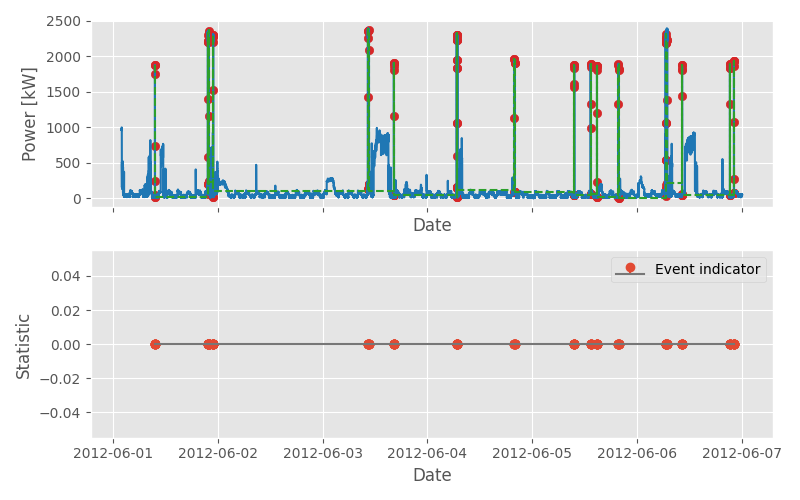

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(8 ,5), sharex=True)
plot_events(input_ts[("power", "filtered")], gof_events.delta_median, gof_events.pos_event_median, ax[0])
plot_statistics(gof_events.statistic_1, ax[1])
plt.tight_layout()

### GOF with voting window

In [29]:
gof_vote_detector = GOFVoteDetector(event_threshold=min_power, stat_window=7, event_window=15, vote_threshold=14)
gof_vote_events = gof_vote_detector.offline_events(pd.DataFrame(input_ts[("power", "filtered")]))

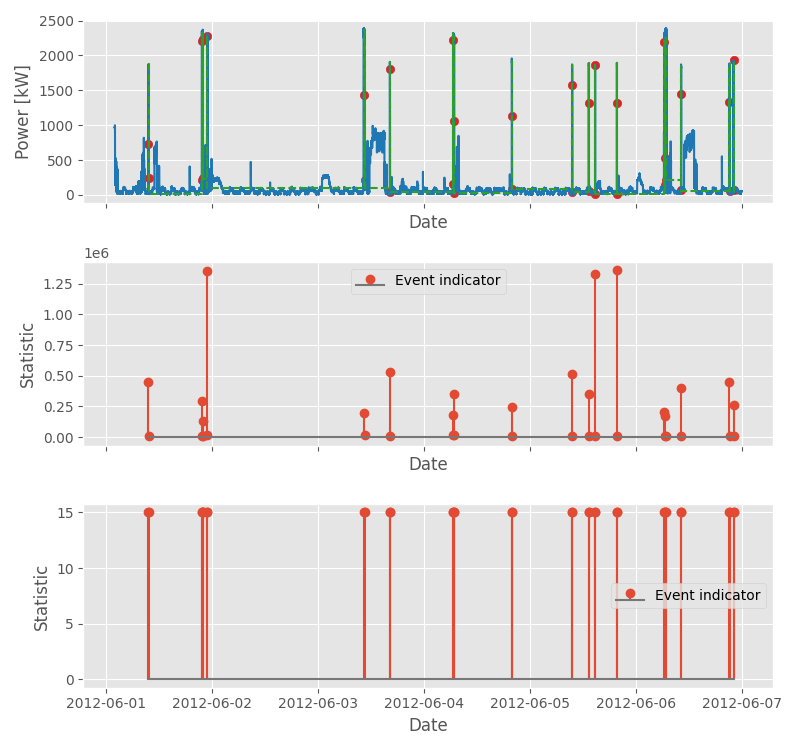

In [30]:
fig, ax = plt.subplots(3, 1, figsize=(8 ,7.5), sharex=True)
plot_events(input_ts[("power", "filtered")], gof_vote_events.delta_median, gof_vote_events.pos_event_median, ax[0])
plot_statistics(gof_vote_events.statistic_1, ax[1])
plot_statistics(gof_vote_events.statistic_2, ax[2])
plt.tight_layout()